In [6]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely import vectorized
import xarray as xr

/tmp/ipykernel_1742582/590470034.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  korea = gdf_borders[gdf_borders['SOVEREIGNT'].isin(['South Korea'])].geometry.unary_union
/tmp/ipykernel_1742582/590470034.py:20: RuntimeWarning: All-NaN slice encountered
  monthly_max = np.array([np.nanmax(daily_max[month * 30:(month + 1) * 30], axis=0) for month in range(12)])


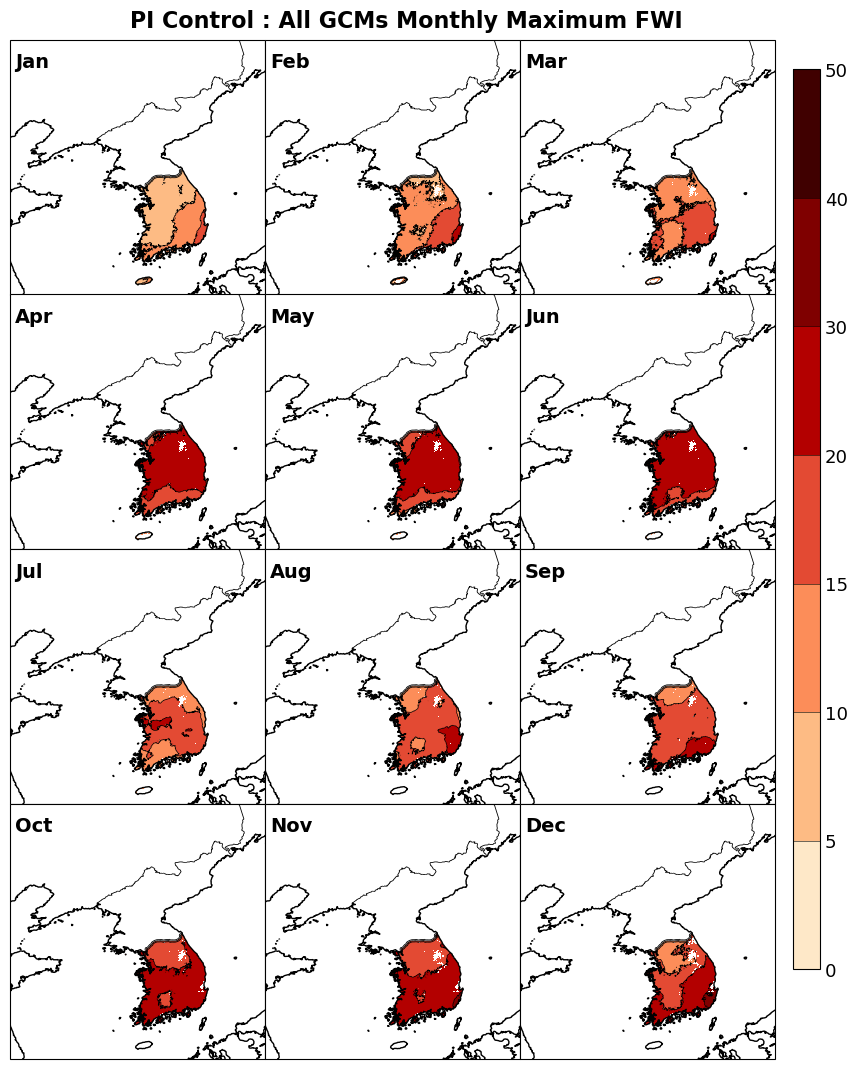

In [ ]:

data_type = "picontrol" 

data_type_title = "PI Control" if data_type == "picontrol" else "Historical"
title = f"{data_type_title} : All GCMs Monthly Maximum FWI"

# 📌 데이터 로드
data_dir = f"../result/HR/{data_type}"
daily_max = np.load(f"{data_dir}/all_gcm_fwi.npy")  # (365 or 366, 601, 601)

shapefile_path = "./shape_files/ne_10m_admin_0_countries.shp"
gdf_borders = gpd.read_file(shapefile_path)
korea = gdf_borders[gdf_borders['SOVEREIGNT'].isin(['South Korea'])].geometry.unary_union

lon = np.load("../../data/ISIMIP_ko_lon_2km.npy")  # (601,)
lat = np.load("../../data/ISIMIP_ko_lat_2km.npy")  # (601,)

lon_grid, lat_grid = np.meshgrid(lon, lat)
mask = vectorized.contains(korea, lon_grid, lat_grid)

# 📌 월별 최대값 계산
monthly_max = np.array([np.nanmax(daily_max[month * 30:(month + 1) * 30], axis=0) for month in range(12)])

# 📌 색상 및 경계 설정
bounds = [0, 5, 10, 15, 20, 30, 40, 50]
colors = ["#fee8c8", "#fdbb84", "#fc8d59", "#e34a33", "#b30000", "#7f0000", "#400000"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 📌 지도 설정
fig, axes = plt.subplots(4, 3, figsize=(9, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(left=0, right=0.85, top=1, bottom=0, hspace=-0.415, wspace=0)  # 🔹 세로/가로 간격 완전 제거

month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, ax in enumerate(axes.flat):
    if i < 12:  # 12개월까지만 그리기
        monthly_max[i] = np.where(mask, np.flipud(monthly_max[i]), np.nan)
        c = ax.pcolormesh(lon, lat, monthly_max[i], cmap=cmap, norm=norm, shading="auto")

        # 🔹 지도 스타일 조정
        ax.coastlines(color="black", linewidth=1.0)
        ax.add_feature(cfeature.BORDERS, linestyle="-", edgecolor="black", linewidth=0.6)
        
        ax.contour(lon, lat, monthly_max[i], levels=bounds, colors='black', linewidths=0.5)

        # 🔹 X, Y 라벨 제거하고 월 이름만 남기기
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.02, 0.95, month_labels[i], transform=ax.transAxes, fontsize=14, fontweight="bold", va="top", ha="left")
    else:
        ax.axis("off")  # 남은 빈 공간 제거


# 📌 컬러바 추가 (오른쪽 배치, 제목과 겹치지 않도록 조정)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.75])  # (left, bottom, width, height)
cbar = fig.colorbar(c, cax=cbar_ax, orientation="vertical", ticks=bounds, drawedges=True)
# cbar.set_label("FWI Max", fontsize=13, fontweight="bold")

# 📌 컬러바 폰트 크기 및 눈금 조정
cbar.ax.tick_params(size=0, width=0, labelsize=13)
cbar.ax.yaxis.set_tick_params(width=1.5)

plt.suptitle(title, fontsize=16, fontweight="bold", x=0.44, y=0.95)
plt.savefig(f"./figs/{data_type}_all_gcms_monthly_max_FWI.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_1742582/4278154432.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  korea = gdf_borders[gdf_borders['SOVEREIGNT'].isin(['South Korea'])].geometry.unary_union


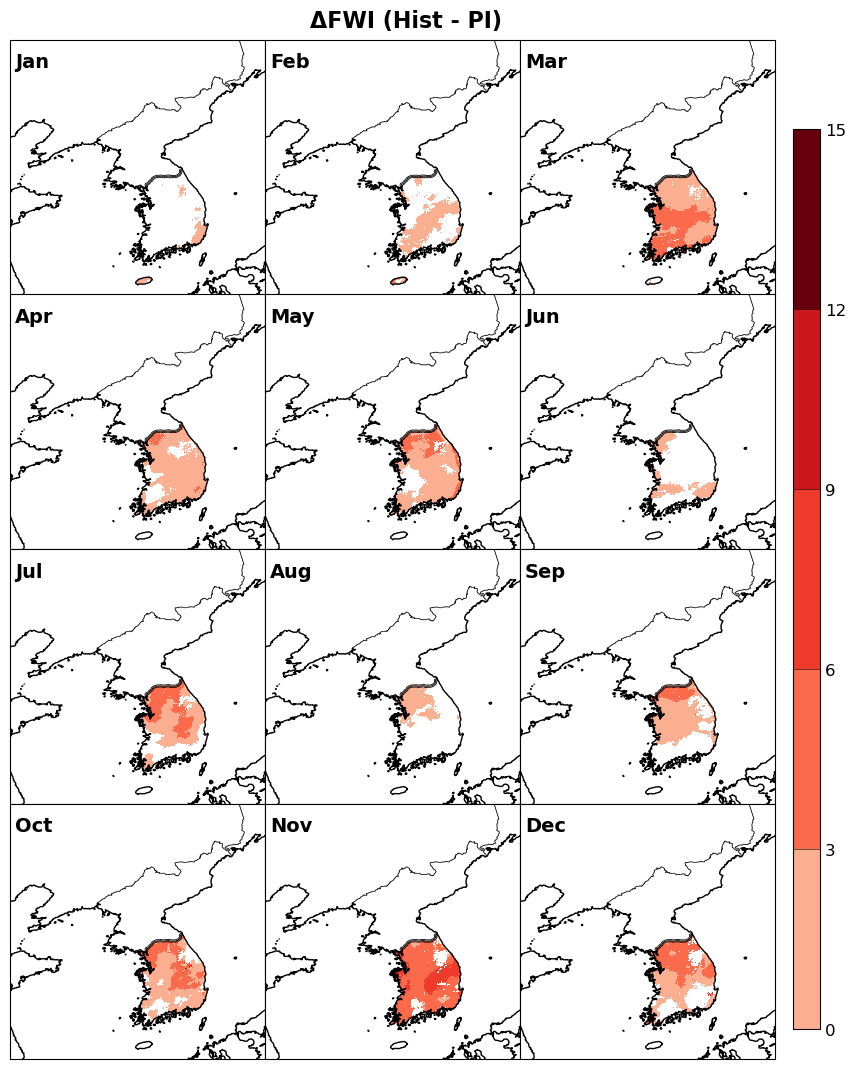

In [ ]:


hist_path = f"../result/HR/historical/all_gcm_fwi.nc"
pi_path = f"../result/HR/picontrol/all_gcm_fwi.nc"

shapefile_path = "./shape_files/ne_10m_admin_0_countries.shp"
gdf_borders = gpd.read_file(shapefile_path)
korea = gdf_borders[gdf_borders['SOVEREIGNT'].isin(['South Korea'])].geometry.unary_union

ds_hist = xr.open_dataset(hist_path)
ds_pi = xr.open_dataset(pi_path)

# 🔹 월별 최대값 계산
hist_monthly = ds_hist.FWI_all.groupby("time_mean.month").max(dim="time_mean")
pi_monthly = ds_pi.FWI_all.groupby("time_mean.month").max(dim="time_mean")

# 🔹 ΔFWI 계산 (Historical - PI-Control)
delta_fwi = hist_monthly - pi_monthly

# 📌 색상 및 경계 설정
bounds = np.arange(0, 18, 3)  # -15에서 15까지 3 간격으로 설정
colors = ["#fcae91", "#fb6a4a", "#ef3b2c", "#cb181d", "#67000d"]   # 더 진한 색상
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 📌 지도 설정
fig, axes = plt.subplots(4, 3, figsize=(9, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(left=0, right=0.85, top=1, bottom=0, hspace=-0.415, wspace=0)  # 🔹 여백 완전 제거

month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

lon = np.load("../../data/ISIMIP_ko_lon_2km.npy")  # (601,)
lat = np.load("../../data/ISIMIP_ko_lat_2km.npy")  # (601,)

lon_grid, lat_grid = np.meshgrid(lon, lat)
mask = vectorized.contains(korea, lon_grid, lat_grid)

for i, ax in enumerate(axes.flat):
    if i < 12:  # 12개월까지만 그리기
        delta_fwi[i] = np.where(mask, np.flipud(delta_fwi[i]), np.nan)
        delta_fwi[i] = np.where(delta_fwi[i]<0, np.nan, delta_fwi[i])
        c = ax.pcolormesh(ds_hist.lon, ds_hist.lat, delta_fwi[i], cmap=cmap, norm=norm, shading="auto")

        # 🔹 지도 스타일 조정
        ax.coastlines(color="black", linewidth=1.0)
        ax.add_feature(cfeature.BORDERS, linestyle="-", edgecolor="black", linewidth=0.6)
        # ax.contour(ds_hist.lon, ds_hist.lat, np.flipud(delta_fwi[i]), levels=bounds, colors='black', linewidths=0.5)

        # 🔹 X, Y 라벨 제거하고 월 이름만 남기기
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.02, 0.95, month_labels[i], transform=ax.transAxes, fontsize=14, fontweight="bold", va="top", ha="left")
    else:
        ax.axis("off")  # 남은 빈 공간 제거

# 📌 컬러바 추가 (오른쪽 배치)
cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75])  # (left, bottom, width, height)
cbar = fig.colorbar(c, cax=cbar_ax, orientation="vertical", ticks=bounds, drawedges=True)
# cbar.set_label("FWI diff", fontsize=14, fontweight="bold")

# 📌 컬러바 폰트 크기 및 눈금 조정
cbar.ax.tick_params(size=0, width=0, labelsize=12)
cbar.ax.yaxis.set_tick_params(width=1.5)

plt.suptitle("ΔFWI (Hist - PI)", fontsize=16, fontweight="bold", x=0.44, y=0.95)

# 🔹 고해상도로 저장
plt.savefig(f"./figs/delta_all_fwi_discrete.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_1742582/3219696852.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  korea = gdf_borders[gdf_borders['SOVEREIGNT'].isin(['South Korea'])].geometry.unary_union


Busan 2/27 -> 2/2
Chungcheongbuk-do 4/7 -> 3/25
Chungcheongnam-do 3/4 -> 3/22
Daegu 4/4 -> 3/25
Daejeon 4/15 -> 3/26
Gangwon-do 4/8 -> 4/10
Gwangju 4/15 -> 3/26
Gyeonggi-do 4/17 -> 4/9
Gyeongsangbuk-do 2/2 -> 2/2
Gyeongsangnam-do 2/27 -> 2/2
Incheon 3/24 -> 3/22
Jellanam-do 4/15 -> 3/4
Jeonbuk-do 3/4 -> 3/26
Sejong-si 4/15 -> 4/9
Seoul 4/17 -> 4/17
Ulsan 2/2 -> 2/1


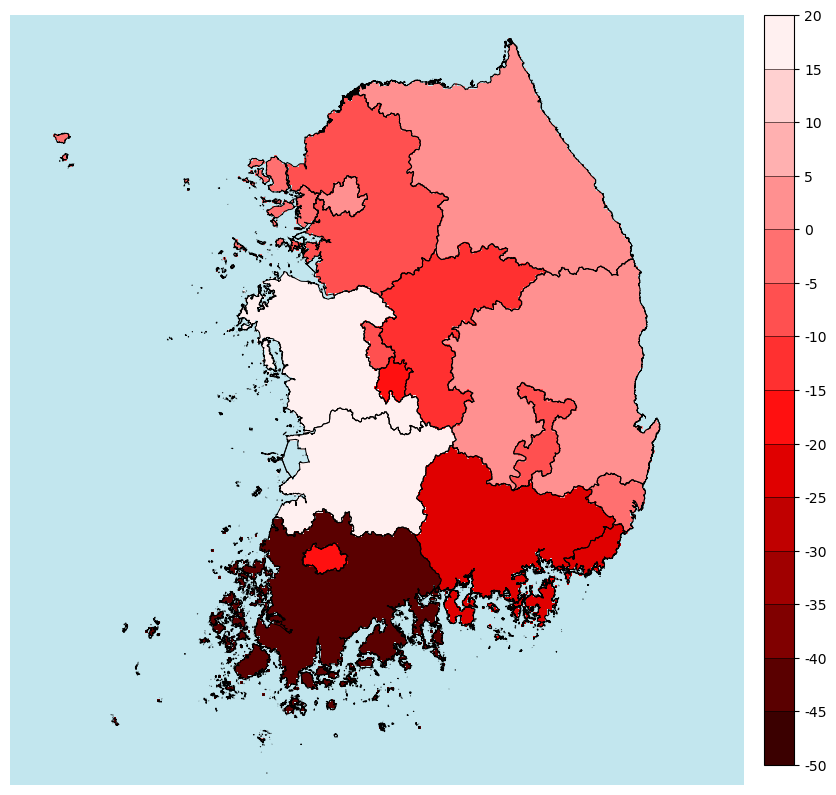

In [14]:

from PIL import Image
from matplotlib.colors import ListedColormap

def day_to_month_day(day_number):
    """
    1~365 사이의 숫자를 월/일로 변환 (비윤년 기준)
    """
    if not 1 <= day_number <= 365:
        raise ValueError("day_number는 1~365 사이여야 합니다.")
    
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    cumulative_days = 0
    
    for month, days_in_month in enumerate(month_days, start=1):
        if day_number <= cumulative_days + days_in_month:
            day = day_number - cumulative_days
            return month, str(day)
        cumulative_days += days_in_month

Sido = Image.open('../../data/sido_total.png')

sido_name = [
    "",
    "Busan",
    "Chungcheongbuk-do",
    "Chungcheongnam-do",
    "Daegu",
    "Daejeon",
    "Gangwon-do",
    "Gwangju",
    "Gyeonggi-do",
    "Gyeongsangbuk-do",
    "Gyeongsangnam-do",
    "Incheon",
    "Jeju-do",
    "Jellanam-do",
    "Jeonbuk-do",
    "Sejong-si",
    "Seoul",
    "Ulsan",
]

shapefile_path = "./shape_files/ne_10m_admin_0_countries.shp"
gdf_borders = gpd.read_file(shapefile_path)
korea = gdf_borders[gdf_borders['SOVEREIGNT'].isin(['South Korea'])].geometry.unary_union

lon = np.load("../../data/ISIMIP_ko_lon_2km.npy")  # (601,)
lat = np.load("../../data/ISIMIP_ko_lat_2km.npy")  # (601,)

lon_grid, lat_grid = np.meshgrid(lon, lat)
ko_mask = vectorized.contains(korea, lon_grid, lat_grid)

aa_hist = np.load("../result/HR/historical/all_gcm_fwi.npy")  # (365, 5, 601, 601)

hist_mask = aa_hist > 20
hist_first_valid_idx = np.argmax(hist_mask, axis=0)
all_false = ~np.any(hist_mask, axis=0)
hist_first_valid_idx[all_false] = 99999

aa_pi = np.load("../result/HR/picontrol/all_gcm_fwi.npy")  # (365, 5, 601, 601)

pi_mask = aa_pi > 20
pi_first_valid_idx = np.argmax(pi_mask, axis=0)
all_false = ~np.any(pi_mask, axis=0)
pi_first_valid_idx[all_false] = 99999

temp_data = {}
sido_array = np.array(Sido.getdata())[:,0]

# np.save("./sido_array.npy", sido_array)
for sido in sido_name:
    # print(sido)
    temp_data[sido] = [99999, 99999, 99999] # hist first, pi first, hist-pi

hist_1d = hist_first_valid_idx.reshape(-1)
pi_1d = pi_first_valid_idx.reshape(-1)

for d in range(len(hist_1d)):
    sido_idx = sido_array[d]
    if hist_1d[d] != 99999:
        if sido_idx > 0 and sido_idx <= len(sido_name):
            temp_data[sido_name[sido_idx]][0] = hist_1d[d] if temp_data[sido_name[sido_idx]][0] > hist_1d[d] else temp_data[sido_name[sido_idx]][0]
    if pi_1d[d] != 99999:
        if sido_idx > 0 and sido_idx <= len(sido_name):
            temp_data[sido_name[sido_idx]][1] = pi_1d[d] if temp_data[sido_name[sido_idx]][1] > pi_1d[d] else temp_data[sido_name[sido_idx]][1]

for sido in sido_name:
    temp_data[sido][2] = temp_data[sido][0] - temp_data[sido][1]

for sido in sido_name:
    if temp_data[sido][0] != 99999:
        pi_mon, pi_day = day_to_month_day(temp_data[sido][1]+1)
        hist_mon, hist_day = day_to_month_day(temp_data[sido][0]+1)
        print(sido, f"{pi_mon}/{pi_day} -> {hist_mon}/{hist_day}")
# sido_value_map = {i: temp_data.get(name, np.nan) for i, name in enumerate(sido_name)}

sido_value_map = {i: temp_data[name][2] for i, name in enumerate(sido_name)}

sido_array = np.array(sido_array).reshape(601,601)
# (601, 601) 시도별 값 이미지 생성
value_image = np.full_like(hist_first_valid_idx, fill_value=np.nan, dtype=float)
for i in range(601):
    for j in range(601):
        sido_idx = sido_array[i, j]
        if sido_idx in sido_value_map:
            value_image[i, j] = sido_value_map[sido_idx]

# 좌표 정보 불러오기
lon = np.load("../../data/ISIMIP_ko_lon_2km.npy")  # (601,)
lat = np.load("../../data/ISIMIP_ko_lat_2km.npy")  # (601,)
lon_grid, lat_grid = np.meshgrid(lon, lat)

mask = sido_array > 0

# 3. value_image에 마스크 적용
value_image = np.where(mask, value_image, np.nan)

shapefile_path = "./shape_files/ctprvn.shp"
sido_gdf = gpd.read_file(shapefile_path)
sido_gdf.set_crs(epsg=5179, inplace=True)  # 좌표계 설정 (metadata만 설정)

# EPSG:4326 (WGS84 위경도)로 변환
sido_gdf = sido_gdf.to_crs(epsg=4326)
bounds = np.arange(-50, 21, 5)  # [-50, -45, ..., 20]


pink_cmap = ListedColormap([
    "#fff0f0", "#ffd0d0", "#ffb0b0", "#ff9090", "#ff7070", "#ff5050", "#ff3030", 
    "#ff1010", "#e00000", "#c00000", "#a00000", "#800000", "#5a0000", "#3b0000"][::-1]
    )

# bounds는 위랑 동일
norm = mcolors.BoundaryNorm(bounds, len(pink_cmap.colors))

# 2. 시각화
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

sido_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.7)

cf = ax.pcolormesh(
    lon[200:-100], lat[45:-300],
    np.flipud(value_image)[45:-300, 200:-100],
    cmap=pink_cmap,
    norm=norm,
    shading='auto'
)

ax.set_extent([
    lon[200], lon[-100],
    lat[45], lat[-300]
], crs=ccrs.PlateCarree())
ax.set_facecolor('#C2E6EE')
for spine in ax.spines.values():
    spine.set_visible(False)

# 3. 컬러바 - boundaries 지정해서 tick 맞추기
cbar_ax = fig.add_axes([0.9, 0.13, 0.03, 0.75])  # (left, bottom, width, height)
cbar = fig.colorbar(cf, cax=cbar_ax, orientation="vertical", ticks=bounds, drawedges=True)
cbar.ax.set_yticklabels([f'{int(b)}' for b in bounds])  # 라벨 정리
# plt.suptitle("FWI>20 First day", fontsize=16, fontweight="bold")
plt.savefig("./figs/delta_first_day.png", dpi=300, bbox_inches="tight")
plt.show()